# How to Build a Faster Vision Transformer for Supervised Image Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scaleapi/dev-blog/blob/main/exchange-vision-transformer/transformer_vision.ipynb)

**Subtitle**: Here's how to implement a vision transformer in Python and speed up its operations by adding a TokenLearner layer.

**Summary**: A vision transformer learns from image data by treating image patches as tokens. Adding a token learning layer to a vision transformer speeds up its operations. 

**Byline**: Mehreen Saeed 

**Keywords**: Vision transformer, TokenLearner, Faster vision transformer

**Byline**: Mehreen Saeed


In their seminal paper "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)," Ashish Vaswani and colleagues proposed the transformer architecture solely based on [the attention mechanism](https://exchange.scale.com/home/blogs/attention-models-what-they-are-and-why-they-matter). Engineers have successfully applied this model to implement many natural language processing tasks. Later in 2021, [Alexey Dosovitskiy and his co-authors](https://arxiv.org/abs/2010.11929) showed how to modify the transformer architecture to solve problems in the computer vision domain. The only addition to the pure transformer is an added layer that breaks up an image into smaller image patches that act like tokens. 

The resulting model, called a "vision transformer" (ViT), works well for image data. However, the training phase of ViTs involves many operations and can be pretty slow. [Michael Ryoo and his colleagues](https://proceedings.neurips.cc/paper/2021/hash/6a30e32e56fce5cf381895dfe6ca7b6f-Abstract.html) showed one possible method of speeding up the computations of the training stage by adding a token learning layer called TokenLearner to the network.

In an earlier tutorial, I showed [how to build a transformer for supervised classification of text documents](https://exchange.scale.com/public/blogs/how-to-build-a-transformer-for-supervised-classification). This time, I'll modify this model to build a ViT and use it to classify images. As a second step, I'll show you how to add a token learning layer to the transformer model to create a faster ViT model. 

My goal is to show you how the ViT works and how the token learner improves its performance. I'll keep everything simple; you won't see any fancy preprocessing or sophisticated fine-tuning of the model to beat the accuracy of existing systems. 

## Prerequisites
Before we get started, be aware that you'll need some background knowledge to understand this tutorial. If you are at a beginning stage, I suggest you first read through these articles, in sequence:

- [Attention Models: What They Are and Why They Matter](https://exchange.scale.com/public/blogs/attention-models-what-they-are-and-why-they-matter)
- [Transformers: What They Are and Why They Matter](https://exchange.scale.com/public/blogs/transformers-what-they-are-and-why-they-matter)
- [How to Build a Transformer for Supervised Classification Using Keras and TensorFlow]( https://exchange.scale.com/public/blogs/how-to-build-a-transformer-for-supervised-classification)

## The Overall ViT Architecture

The ViT you are about to build has the structure shown in Figure 1. After tokenizing the image, the transformer passes the token images through an embedding layer, followed by four encoder layers. The output from the last encoder layer is input to a global average pooling layer and then passed through a feedforward neural network. 

![](https://lh6.googleusercontent.com/_DI8dfWg8LGLzFithZhMiyyZyAf9jOocrHrzfaA67uYvnh9IpskZksi0FSujFSQ5Hcrb1cVL75XwNWYKcJPvNz6CofjXXAKdKANN59N2pjm3iiBXXJXwqFjReZbII-k-qg=w1280)

*Figure 1: The vision transformer architecture. Source: Mehreen Saeed*

## The Import Section

As a first step, import the following libraries:

In [ ]:
# Different layers
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense, Reshape
from tensorflow.keras.layers import LayerNormalization, Layer
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, Dropout
# For miscellaneous functions
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import reduce_mean, float32, range, reshape
from tensorflow.keras import utils
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.nn import gelu
from tensorflow.keras import Model, Sequential
# For tokenization
from tensorflow.image import extract_patches

# For math/arrays
import numpy as np
# For plotting
import matplotlib.pyplot as plt
# For profiling
import time

## Load the Dataset
We'll use the [Fashion-MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist), which consists of 28-by-28 grayscale images of different fashion items. In the code below, I have set *n_classes* to four so that you can run this code quickly on four classes. Change this value to 10 to run the example on the entire dataset.

The following code reads the dataset and prints some statistics.

In [ ]:
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()
input_shape = train_X[0].shape

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
n_classes = 4
ind = np.where(train_Y<n_classes)[0]
train_X = np.array(list(map(train_X.__getitem__, ind)))
train_Y = np.array(list(map(train_Y.__getitem__, ind)))
print('\n Training data shape:', train_X.shape, 'training labels shape:', train_Y.shape)

ind = np.where(test_Y<n_classes)[0]
test_X = np.array(list(map(test_X.__getitem__, ind)))
test_Y = np.array(list(map(test_Y.__getitem__, ind)))
print('\n Test data shape:', test_X.shape, 'test labels shape:', test_Y.shape)

# Convert labels to categorical labels
train_Y_categorical = utils.to_categorical(train_Y)
test_Y_categorical  = utils.to_categorical(test_Y)


 Training data shape: (24000, 28, 28) training labels shape: (24000,)

 Test data shape: (4000, 28, 28) test labels shape: (4000,)


As these images are grayscale, but you can reshape them to a 3D array with one color channel. This way, this code will work for RGB images as well.

In [ ]:
# Reshape gray scale so that the model works with RGB images as well
if (len(train_X.shape) == 3):
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)).astype('float32')
    test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)).astype('float32')

## The Image Tokenizer Layer

For image data, the key is to understand what a token represents. One possibility is to let each pixel represent a token. However, this would not scale well with large image datasets. In the ViT architecture, Dosovitskiy and his colleagues used equal-sized patches of images to act as tokens. This sequence of tokens is then input to a traditional transformer with a minimal change to its architecture. 

Fortunately, the TensorFlow library includes an *extract_patches()* method to break an image into smaller patches of fixed size. You can use this function to implement your own layer for tokenizing an image. In the code below, *ImageTokenizerLayer* is a custom class for tokenizing images. The *call()* method of this class creates the image patches and returns them.

In [ ]:
class ImageTokenizerLayer(Layer):
    def __init__(self, token_shape):
        super(ImageTokenizerLayer, self).__init__()
        self.token_shape = token_shape

    def call(self, images):
        tokens = extract_patches(
            images = images,
            sizes = [1, self.token_shape[0], self.token_shape[1], 1],
            strides = [1, self.token_shape[0], self.token_shape[1], 1],
            rates = [1, 1, 1, 1],
            padding = "VALID",
        )
        return tokens

Because the tokenization step is needed only once, you can store the tokens corresponding to the training set and use them as input to the ViT. In the code below, the dimensions of each token are the square root of the dimensions of the training and test images. However, you can change the patch size to a different value also. The two variables *train_tokens* and *test_tokens* store fixed-size tokens of each image. The tokens are also rendered below. 

A few things to note:

- A single input image has 28 by 28 dimensions.
- The input image is broken into 25 tokens of size 5 by 5.
- Each 5-by-5 image token/patch is vectorized into a 1D array of size 25.
- In the tokenized training dataset, each image is split into a sequence of tokens. One image has 5-by-5-by-25 dimensional representation.
- *n_rows* and *n_cols* represent the total image tokens along the rows and columns, respectively. The total number of image tokens is, therefore, *n_rows * n_cols*.

Train data shape (24000, 28, 28, 1)
Train tokens shape (24000, 5, 5, 25)


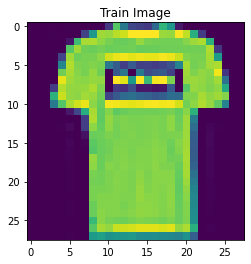

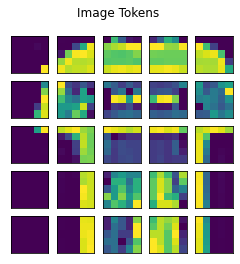

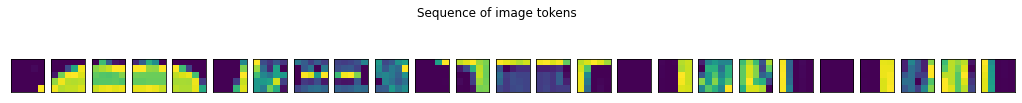

In [ ]:
def display_tokens(img, tokenized_img):   
    # Check if RGB or grayscale image
    if (img.shape[-1] == 3):    
        img = img[:,:,:]
    else:
        img = img[:,:,0]
    plt.imshow(img.astype("uint8"))
    plt.title('Train Image')
    
    fig, ax = plt.subplots(nrows=tokenized_img.shape[0], 
                           ncols=tokenized_img.shape[1], 
                           figsize=(4, 4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    for i in range(tokenized_img.shape[0]):
        for j in range(tokenized_img.shape[1]):
            # Check if it an RGB image
            if (tokenized_img.shape[-1] == 3):
                token = np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1], 3))
            else: 
                # Show graysclae
                token =  np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1]))
            ax[i,j].imshow(token)
    plt.gcf().suptitle('Image Tokens')   
    
    fig, ax = plt.subplots(nrows=1, 
                           ncols=tokenized_img.shape[0]*tokenized_img.shape[1], 
                           figsize=(18, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    for i in range(tokenized_img.shape[0]):
        for j in range(tokenized_img.shape[1]):
            # Check if it an RGB image
            if (tokenized_img.shape[-1] == 3):
                token = np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1], 3))
            else: 
                # Show graysclae
                token = np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1]))
            ax[i*tokenized_img.shape[1] + j].imshow(token)
    plt.gcf().suptitle('Sequence of image tokens')      
    plt.show()
    
# Take the square root of dimensions of the input image     
token_dims = np.round(np.sqrt(train_X[0].shape)).astype("uint8")    
train_tokens = ImageTokenizerLayer(token_dims)(train_X)
test_tokens = ImageTokenizerLayer(token_dims)(test_X)
n_rows=train_tokens.shape[1]
n_cols=train_tokens.shape[2]

print('Train data shape', train_X.shape)
print('Train tokens shape', train_tokens.shape)
# Display the original and image tokens
display_tokens(train_X[0], train_tokens[0])

## Writing a Customized Embedding Layer for the ViT

In a pure transformer architecture, all word tokens are encoded by summing  their embeddings and their encoded positions. In the case of a ViT, the embedding layer projects an image linearly and sums it with its corresponding positional encoding. In this way, the positional encoding helps retain the order of a token in the sequence.

Below, you can see the implementation of a custom layer for encoding each image token. The *call()* method implements the following steps:

1. Normalize the input image tokens.
1. Project the normalized image tokens by using a *Dense* layer.
1. Encode the positions using TensorFlow *Embedding* layer.
1. Add the projections and the encoded positions. Return their sum.

Here, the length of the resulting embedding is stored in the variable *embed_dim*, whose value can be set by a user. Hence, the embedding layer produces an output of size *total_tokens x embed_dim*. Again, keep in mind that *total_tokens = n_rows * ncols*.

In [ ]:
class ImageEmbeddingLayer(Layer):
    def __init__(self, output_dim):
        super(ImageEmbeddingLayer, self).__init__()
        self.output_dim = output_dim

    # Need to define the Dense layer for linear projections 
    # Embedding layer for positions
    def build(self, input_shape):      
        self.total_img_tokens = input_shape[1]*input_shape[2]
        self.token_dims = input_shape[3]
        self.normalize_layer = LayerNormalization()
        self.dense = Dense(units=self.output_dim, 
                                  input_shape=(None, self.token_dims))
        self.position_embedding = Embedding(input_dim=self.total_img_tokens, 
                                                   output_dim=self.output_dim)
        
    def call(self, input):  
        img_tokens = reshape(input, [-1, self.total_img_tokens,
                                            self.token_dims])
        normalized_img_token = self.normalize_layer(img_tokens)
        img_projection = self.dense(normalized_img_token)
        all_positions = range(start=0, limit=self.total_img_tokens, delta=1)
        positions_encoding = self.position_embedding(all_positions)
        
        return positions_encoding + img_projection       

## The Encoder Layer

In "[How to Build a Transformer for Supervised Classification]( https://exchange.scale.com/public/blogs/how-to-build-a-transformer-for-supervised-classification)," I showed you how to build a single encoder layer by sub-classing the *Layer* class. We'll use the same implementation for the ViT. Just to recall, the encoder layer implements multihead attention followed by a feedforward network and a normalization layer.

In [ ]:
class EncoderLayer(Layer):
    def __init__(self, total_heads, total_dense_units, embed_dim):
        super(EncoderLayer, self).__init__()
        # Multihead attention layer
        self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)
        # Feed forward network layer
        self.nnw = Sequential(
                            [Dense(total_dense_units, activation="relu"),
                             Dense(embed_dim)])
        # Normalization
        self.normalize_layer = LayerNormalization()

    def call(self, inputs):
        attn_output = self.multihead(inputs, inputs)
        normalize_attn = self.normalize_layer(inputs + attn_output)
        nnw_output = self.nnw(normalize_attn)
        final_output = self.normalize_layer(normalize_attn + nnw_output)
        return final_output

## Build the ViT

It's time to construct the final ViT model from the *ImageEmbeddingLayer* and *EncoderLayer*. The final output of the transformer is produced by a softmax layer, where each unit of the layer corresponds to a category of the input image.

The code below constructs a ViT with four encoder layers followed by *GlobalAveragePooling1D* layer, an intermediate *Dense* layer, and the output *Dense* layer (refer to Figure 1). 

In [ ]:
# Set the hyperparameters
EMBED_DIM = 128
NUM_HEADS = 3
TOTAL_DENSE = 100
EPOCHS = 6
FINAL_DENSE = 150
DROPOUT = 0.5

# Should return the model
def build_vit(input_shape, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, total_dense_units=TOTAL_DENSE):
    # Start connecting layers
    inputs = Input(shape=input_shape)
    embedding_layer = ImageEmbeddingLayer(embed_dim)(inputs)
    encoder_layer1 = EncoderLayer(num_heads, total_dense_units, embed_dim)(embedding_layer)
    encoder_layer2 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer1)
    encoder_layer3 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer2)
    encoder_layer4 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer3)
    pooling_layer = GlobalAveragePooling1D()(encoder_layer4)
    dense_layer = Dense(FINAL_DENSE, activation='relu')(pooling_layer)
    dropout_layer = Dropout(DROPOUT)(dense_layer)
    outputs = Dense(n_classes, activation="softmax")(dense_layer)
    
    # Construct the transformer model
    ViT = Model(inputs=inputs, outputs=outputs)   
    ViT.compile(optimizer="adam", loss='categorical_crossentropy', 
                          metrics=['accuracy', 'Precision',
                                   'Recall',
                                   TopKCategoricalAccuracy(5, name='top-5-accuracy')])
    return ViT

vit = build_vit(train_tokens[0].shape)

Let's look at the model summary. 

In [ ]:
vit.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5, 25)]        0         
                                                                 
 image_embedding_layer (Imag  (None, 25, 128)          6578      
 eEmbeddingLayer)                                                
                                                                 
 encoder_layer (EncoderLayer  (None, 25, 128)          223972    
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  (None, 25, 128)          223972    
 er)                                                             
                                                                 
 encoder_layer_2 (EncoderLay  (None, 25, 128)          223972    
 er)                                                         

## Training the ViT
The code below trains the transformer model using a 33% split for the validation set.

In [ ]:
start_time = time.time()
history = vit.fit(train_tokens, train_Y_categorical, 
                  batch_size=32, epochs=EPOCHS, validation_split=0.33)
end_time = time.time()
print('\nViT training time: ', end_time-start_time)

Epoch 1/6
503/503 [==============================] - 110s 210ms/step - loss: 0.4088 - accuracy: 0.8528 - precision: 0.8704 - recall: 0.8325 - top-5-accuracy: 1.0000 - val_loss: 0.3440 - val_accuracy: 0.8826 - val_precision: 0.8926 - val_recall: 0.8717 - val_top-5-accuracy: 1.0000
Epoch 2/6
503/503 [==============================] - 104s 206ms/step - loss: 0.2743 - accuracy: 0.9077 - precision: 0.9177 - recall: 0.8979 - top-5-accuracy: 1.0000 - val_loss: 0.2683 - val_accuracy: 0.9097 - val_precision: 0.9237 - val_recall: 0.8962 - val_top-5-accuracy: 1.0000
Epoch 3/6
503/503 [==============================] - 104s 207ms/step - loss: 0.2652 - accuracy: 0.9092 - precision: 0.9204 - recall: 0.9005 - top-5-accuracy: 1.0000 - val_loss: 0.2399 - val_accuracy: 0.9166 - val_precision: 0.9278 - val_recall: 0.9078 - val_top-5-accuracy: 1.0000
Epoch 4/6
503/503 [==============================] - 103s 204ms/step - loss: 0.2918 - accuracy: 0.9027 - precision: 0.9143 - recall: 0.8914 - top-5-accuracy:

### View the Learning History
The `history` object stores the learning history of our model. The `fit()` method returns the following keys in the `history.history` object.

In [ ]:
print('\nMetrics recorded during training', history.history.keys(), '\n')


Metrics recorded during training dict_keys(['loss', 'accuracy', 'precision', 'recall', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_top-5-accuracy']) 



Let's visualize the learning history by plotting various metrics. 

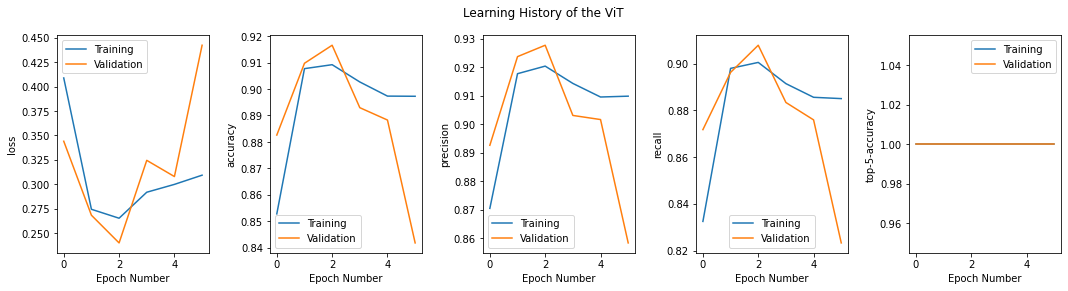

In [ ]:
n_metrics = int(len(history.history.keys())/2)
metrics = list(history.history.values())
metric_names = list(history.history.keys())

fig = plt.figure(figsize=(18,4))
for i in np.arange(n_metrics):
    fig.add_subplot(101 + n_metrics*10 +i)    
    plt.plot(metrics[i])
    plt.plot(metrics[i+n_metrics])
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch Number')
    plt.ylabel(metric_names[i])

plt.gcf().suptitle('Learning History of the ViT')    
plt.subplots_adjust(wspace=0.4)    
plt.show()

## Evaluating the ViT's Classification Performance

The *evaluate()* method returns all the metrics that you specified during the training stage.

In [ ]:
train_metrics = vit.evaluate(train_tokens,  train_Y_categorical)
test_metrics  = vit.evaluate(test_tokens,  test_Y_categorical)

125/125 [==============================] - 9s 69ms/step - loss: 0.4731 - accuracy: 0.8315 - precision: 0.8466 - recall: 0.8140 - top-5-accuracy: 1.0000


In [ ]:
print('\nTraining set evaluation of ViT')
for i, value in enumerate(train_metrics):
    print(metric_names[i], ': ', value)
print('\nTest set evaluation of ViT')
for i, value in enumerate(test_metrics):
    print(metric_names[i], ': ', value)


Training set evaluation of ViT
loss :  0.4440799057483673
accuracy :  0.8418333530426025
precision :  0.8573351502418518
recall :  0.8227916955947876
top-5-accuracy :  1.0

Test set evaluation of ViT
loss :  0.47306209802627563
accuracy :  0.8314999938011169
precision :  0.8465938568115234
recall :  0.8140000104904175
top-5-accuracy :  1.0


## How To Make the ViT Faster

While there are several methods for making the ViT faster, we'll implement the *TokenLearner* of Ryoo and colleagues. The *TokenLearner* layer learns to identify important tokens in the input data. It then dynamically selects these tokens conditioned on the input, reducing the number of tokens used for classifying images. This algorithm mimics the element-wise spatial self-attention.

### What is the Basic TokenLearner Algorithm?

Here is the basic algorithm for the layer that implements the *TokenLearner*. In the algorithm below, *n_maps* represents the number of feature maps and is a user-supplied parameter.

1. Compute weight maps conditioned on the inputs. The number of weight maps are *n_maps*. They effectively represent the attention weights. The weights have dimensions *n_rows x n_cols x n_maps*.
1. Reshape the weights to *total_tokens x n_maps*.
1. Multiply the weight maps by the inputs to get weighted inputs. The input size is *total_tokens x embed_dim* and the resulting weighted input size is *total_tokens x n_maps x embed_dim*.
1. Apply spatial global average pooling to reduce the dimensions of the weighted inputs to *n_maps x embed_dim*.

Figure 2 shows all these computations on the left.

![](https://lh3.googleusercontent.com/bBasjBnV0hmKnKAMMiIC-5hzJ508aSyt26GExOQGwZS8XnDgaXEd6l4yrQrhQOwUAjZ5nlymgoGMz_FHo7wJf_OagY-rn4QUoXZuaKhg9DGnrPnf3cDX2pB_ES8LPbKRBQ=w1280)

*Figure 2: The token learning layer. Source: Mehreen Saeed*


### How Is the Weight Map Computed?

Ryoo and colleagues compute the weight map of the *TokenLearner* as follows:

1. Reshape the inputs to *n_rows x n_cols x embed_dim*.
1. Pass the inputs through a series of convolution layers with a [Gaussian Error Linear Unit (GELU)](https://www.tensorflow.org/api_docs/python/tf/nn/gelu) activation function.
1. Pass the convolved output through a convolution layer with sigmoid activation function. The dimensions of the result are *n_rows x n_cols x n_maps*.

The processing is shown on the right in Figure 2.

### Where Is the Token Learner in the Transformer Network?

Ryoo and colleagues suggest you place the *TokenLearner* layer anywhere between the transformer encoder layers. They  experimented with placing this layer at different points in the network. They observed that inserting the *TokenLearner* after the initial one quarter of the network reduces the computations to less than a third of the baseline with no compromise in accuracy. Moreover, if this layer is inserted further down in the network, the resulting model has improved accuracy.

Below is the code for the custom *TokenLearningLayer*. The *fast_vit* transformer model places the *TokenLearningLayer* after the two encoder layers, as shown in the figure below.

![](https://lh6.googleusercontent.com/ZDepbxr_CkgFE8PnlGf3EZ5Re5v1O6PH1wAak2AX3w8zV3L5lCWwSgrRWdRUAq5tPh_QwqB7acORya29ffGzYzge_D_9r0mM5ylIV_qGeKHmxDb51UBmPnpd89c08Q_Sbw=w1280)

*Figure 3: The overall ViT architecture with a token learning layer. Source: Mehreen Saeed*

In [ ]:
class TokenLearningLayer(Layer):
    def __init__(self, n_maps, token_dims):
        super(TokenLearningLayer, self).__init__()
        self.n_maps = n_maps
        self.token_dims = token_dims


    def build(self, input_shape):          
        self.input_embed_dim = input_shape[-1]
        self.model = Sequential()
        
        # Add Reshape layer to make a nrowxncolxembed_dim shape
        self.model.add(Reshape((self.token_dims[0], 
                                self.token_dims[1], self.input_embed_dim)))
        # Connect 4 Conv2D layers
        for i in range(4):
            conv2D_layer = Conv2D(filters=self.n_maps, kernel_size=(3, 3),
                                  activation=gelu, padding="same",
                                  use_bias=False)
            self.model.add(conv2D_layer)
        # Connect with the last conv2D with sigmoid filter    
        conv2D_sigmoid_layer = Conv2D(filters=self.n_maps, kernel_size=(3, 3),
                                      activation="sigmoid", padding="same",
                                      use_bias=False)
        self.model.add(conv2D_sigmoid_layer)
        # Reshape to (batch, nrow*ncol, n_maps)
        self.model.add(Reshape((-1, self.n_maps)))  
        
    def call(self, inputs):
        total_tokens = inputs.shape[1]        
        # attn_wts shape: (batch, row*col, n_maps)
        attn_wts = self.model(inputs)        
        # Reshape inputs and attn_wts to match dimensions for multiplication
        inputs = Reshape((total_tokens, 1, self.input_embed_dim))(inputs)
        attn_wts = Reshape((total_tokens, self.n_maps, 1))(attn_wts)
        # attended_output has shape (batch, row*col, n_maps, embed_dim)    
        attended_output =  inputs*attn_wts
        # Pool the result, will reduce one dimension
        output = reduce_mean(attended_output, axis=1)  
        return output

After creating the *TokenLearningLayer*, you can build the transformer with this layer after two encoder layers.

In [ ]:
NMAPS=4
def build_fast_vit(input_shape, embed_dim=EMBED_DIM, 
              num_heads=NUM_HEADS, total_dense_units=TOTAL_DENSE,
              n_maps=NMAPS):
    # Start connecting layers
    inputs = Input(shape=train_tokens[0].shape)
    #tokenizer_layer = ImageTokenizerLayer(token_dims)(inputs)
    embedding_layer = ImageEmbeddingLayer(embed_dim)(inputs)
    encoder_layer1 = EncoderLayer(num_heads, total_dense_units, embed_dim)(embedding_layer)
    encoder_layer2 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer1)
    token_learning_layer = TokenLearningLayer(n_maps, (n_rows, n_cols))(encoder_layer2)
    encoder_layer3 = EncoderLayer(num_heads, total_dense_units, embed_dim)(token_learning_layer)
    encoder_layer4 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer3)
    pooling_layer = GlobalAveragePooling1D()(encoder_layer4)
    dense_layer = Dense(150, activation='relu')(pooling_layer)
    dropout_layer = Dropout(.5)(dense_layer)
    outputs = Dense(n_classes, activation="softmax")(dense_layer)

    # Construct the transformer model
    fast_vit = Model(inputs=inputs, outputs=outputs)
    fast_vit.compile(optimizer="adam", loss="categorical_crossentropy", 
                              metrics=['accuracy', 'Precision', 'Recall',
                                       TopKCategoricalAccuracy(5, name="top-5-accuracy")])
    return fast_vit

fast_vit = build_fast_vit(train_tokens[0].shape)

Next, let's look at the summary of the model.

In [ ]:
fast_vit.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 25)]        0         
                                                                 
 image_embedding_layer_1 (Im  (None, 25, 128)          6578      
 ageEmbeddingLayer)                                              
                                                                 
 encoder_layer_4 (EncoderLay  (None, 25, 128)          223972    
 er)                                                             
                                                                 
 encoder_layer_5 (EncoderLay  (None, 25, 128)          223972    
 er)                                                             
                                                                 
 token_learning_layer (Token  (None, 4, 128)           5184      
 LearningLayer)                                            

The summary of *fast_vit* model shows that the *token_learning_layer* takes a 25-by-128 input and reduces it to a 4-by-128 output. Hence, the subsequent encoder layers process 4-by-128 inputs—that is, four tokens instead of 25, thereby reducing the overall number of computations for training the ViT.  

In [ ]:
start_time = time.time()
history_fast = fast_vit.fit(train_tokens, train_Y_categorical, 
                       batch_size=32, epochs=EPOCHS, validation_split=0.33)
end_time = time.time()
print('\nTime to train fast_vit', end_time-start_time)

Epoch 1/6
503/503 [==============================] - 75s 141ms/step - loss: 0.4245 - accuracy: 0.8503 - precision: 0.8667 - recall: 0.8332 - top-5-accuracy: 1.0000 - val_loss: 0.3101 - val_accuracy: 0.8900 - val_precision: 0.8996 - val_recall: 0.8827 - val_top-5-accuracy: 1.0000
Epoch 2/6
503/503 [==============================] - 71s 141ms/step - loss: 0.2782 - accuracy: 0.9082 - precision: 0.9179 - recall: 0.8992 - top-5-accuracy: 1.0000 - val_loss: 0.4236 - val_accuracy: 0.8811 - val_precision: 0.8955 - val_recall: 0.8662 - val_top-5-accuracy: 1.0000
Epoch 3/6
503/503 [==============================] - 72s 144ms/step - loss: 0.2576 - accuracy: 0.9143 - precision: 0.9254 - recall: 0.9040 - top-5-accuracy: 1.0000 - val_loss: 0.2209 - val_accuracy: 0.9256 - val_precision: 0.9344 - val_recall: 0.9188 - val_top-5-accuracy: 1.0000
Epoch 4/6
503/503 [==============================] - 72s 143ms/step - loss: 0.2317 - accuracy: 0.9247 - precision: 0.9346 - recall: 0.9150 - top-5-accuracy: 1.0

We can view the learning history of the fast ViT model.

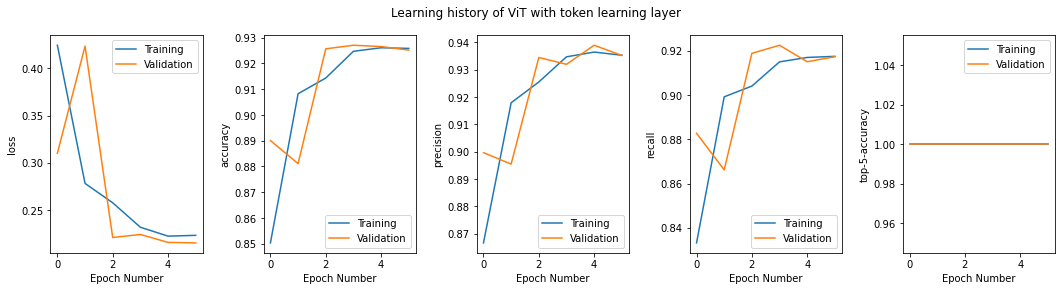

In [ ]:
metrics_fast = list(history_fast.history.values())
fig = plt.figure(figsize=(18,4))
for i in np.arange(n_metrics):
    fig.add_subplot(101 + n_metrics*10 +i)    
    plt.plot(metrics_fast[i])
    plt.plot(metrics_fast[i+n_metrics])
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch Number')
    plt.ylabel(metric_names[i])

plt.gcf().suptitle('Learning history of ViT with token learning layer')
plt.subplots_adjust(wspace=0.4)    
plt.show()

In [ ]:
train_metrics_fast = fast_vit.evaluate(train_tokens,  train_Y_categorical)
test_metrics_fast = fast_vit.evaluate(test_tokens,  test_Y_categorical)

125/125 [==============================] - 5s 42ms/step - loss: 0.2329 - accuracy: 0.9247 - precision: 0.9333 - recall: 0.9160 - top-5-accuracy: 1.0000


In [ ]:
print('\nTraining set evaluation of fast ViT')
for i, value in enumerate(train_metrics_fast):
    print(metric_names[i], ': ', value)
print('\nTest set evaluation of ViT')
for i, value in enumerate(test_metrics_fast):
    print(metric_names[i], ': ', value)


Training set evaluation of fast ViT
loss :  0.19556963443756104
accuracy :  0.9355416893959045
precision :  0.9430433511734009
recall :  0.9285833239555359
top-5-accuracy :  1.0

Test set evaluation of ViT
loss :  0.23290909826755524
accuracy :  0.9247499704360962
precision :  0.9332653880119324
recall :  0.9160000085830688
top-5-accuracy :  1.0


## What Do the Results Indicate?

Adding a *TokenLearningLayer* to the network reduces the number of parameters of the layers following it, which also reduces the training time. In this example, I have used the *time* class to estimate the CPU time for training both the ViT and the fast ViT models. The overall time and the ms/step are both less for the later model. While this may be a crude method to judge the running time of a function, it still gives us a pretty good idea of the reduction in overall computation time. You can use more sophisticated measures for profiling. 

Also, if you run this multiple times, you'll note that the accuracy of both models is about the same, if not better, for the fast ViT model in terms of the metrics. 

For larger datasets with bigger images, you may have deeper networks. In this case, you would see a significant reduction in the number of variables involved and computation time. 

## What's Next?

Now that you know how to build a *TokenLearner* layer, you can experiment with different transformer hyper-parameters including the number of encoder layers, number of heads used in the encoder layer, number of feature maps in the *TokenLearner* and the number of dense units. For larger datasets, you may want to add parameters to stabilize weight training during the training phase. If you want to add the *TokenLearner* again to the transformer, you'll have to use it with a *[TokenFuser](https://proceedings.neurips.cc/paper/2021/hash/6a30e32e56fce5cf381895dfe6ca7b6f-Abstract.html)*, which remaps the feature maps back to their original spatial dimension.

## Learn More

- [An Image Is Worth 16X16 Words: Transformer for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)
- [TokenLearner: Adaptive Space-Time Tokenization for Videos](https://proceedings.neurips.cc/paper/2021/hash/6a30e32e56fce5cf381895dfe6ca7b6f-Abstract.html)
- [Attention Models: What They Are and Why They Matter](https://exchange.scale.com/public/blogs/attention-models-what-they-are-and-why-they-matter)
- [Transformers: What They Are and Why They Matter](https://exchange.scale.com/public/blogs/transformers-what-they-are-and-why-they-matter)
- [How to Build a Transformer for Supervised Classification]( https://exchange.scale.com/public/blogs/how-to-build-a-transformer-for-supervised-classification)
